　「RとStanで始めるベイズ統計モデリングによるデータ分析入門」「実践編第5部第7章 自己回帰モデルとその周辺」を対象に，公開されているR，Stanのコードをpython，pystanのコードへと書き直した一例です。Stanの代わりにpystanを利用しています。

　この章では，古典的な時系列分析の枠組みについて自己回帰モデルの説明を通じ補足しています。

　本ページでは公開されていない書籍の内容については一切触れません。理論や詳しい説明は書籍を参照してください。

　なお，こちらで紹介しているコードには誤りが含まれる可能性があります。内容やコードについてお気づきの点等ございましたら，ご指摘いただけると幸いです

# 分析の準備
## パッケージの読み込み

In [1]:
import arviz
import pystan
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Meiryo'

## データの読み込みと図示
### データの読み込み

In [2]:
sales_df_5 = pd.read_csv('5-7-1-sales-ts-5.csv')
sales_df_5['date'] = pd.to_datetime(sales_df_5['date']) # datetime型へ変換
sales_df_5.head(n=3)

,date,sales
0,2010-01-01,91.0
1,2010-01-02,96.5
2,2010-01-03,113.8


### 図示

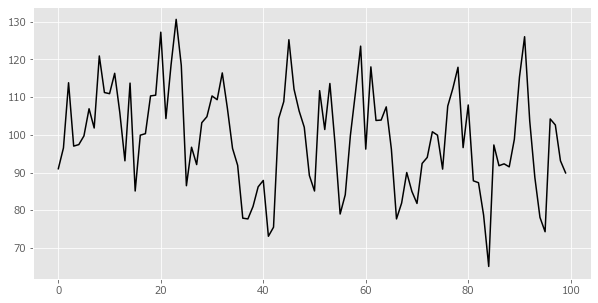

In [4]:
plt.figure(figsize=(10,5))
plt.plot(sales_df_5['sales'], color='black')
plt.show()

# 自己回帰モデルの推定
## データの準備

In [5]:
data_list = dict(y=sales_df_5['sales'], 
                 T=len(sales_df_5))

## 自己回帰モデルの推定

In [6]:
# stanコードの記述（5-7-1-autoregressive.stan）
stan_code = '''
data {
  int T;         // データ取得期間の長さ
  vector[T] y;   // 観測値
}

parameters {
  real<lower=0> s_w;  // 過程誤差の標準偏差
  real b_ar;          // 自己回帰項の係数
  real Intercept;     // 切片
}

model {
  for(i in 2:T) {
    y[i] ~ normal(Intercept + y[i-1]*b_ar, s_w);
  }
}

'''

# モデルのコンパイル
stan_model = pystan.StanModel(model_code=stan_code)

# サンプリング
autoregressive = stan_model.sampling(data=data_list,
                                     seed=1,
                                     control={'max_treedepth': 15},
                                     n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6b9d5d48d86f905b332b7d74ea6a7816 NOW.


## 自己回帰モデルの推定結果

In [7]:
print(
    autoregressive.stansummary(pars=["s_w", "b_ar", "Intercept", "lp__"],
                                probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_6b9d5d48d86f905b332b7d74ea6a7816.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
s_w        11.79    0.02   0.86   10.3  11.74  13.65   1451    1.0
b_ar        0.54  2.5e-3   0.09   0.36   0.54   0.71   1223    1.0
Intercept  46.18    0.25   8.69  29.07  46.03  63.84   1212    1.0
lp__      -290.6    0.03   1.21 -293.6 -290.3 -289.2   1311    1.0

Samples were drawn using NUTS at Sun Sep 13 13:30:41 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## 参考：収束の確認

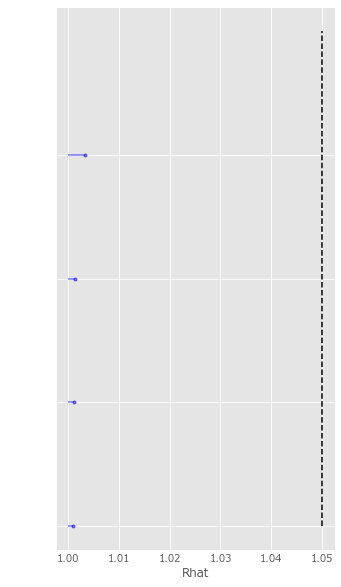

In [8]:
# 収束確認用のRhatのプロット関数
def mcmc_rhat(dataframe, column='Rhat', figsize=(5, 10)):
    plt.figure(figsize=figsize)
    plt.hlines(y=dataframe[column].sort_values().index,
               xmin=1,
               xmax=dataframe[column].sort_values(),
               color='b',
               alpha=0.5)
    plt.vlines(x=1.05, ymin=0, ymax=len(dataframe[column]), linestyles='--')
    plt.plot(dataframe[column].sort_values().values,
             dataframe[column].sort_values().index,
             marker='.',
             linestyle='None',
             color='b',
             alpha=0.5)
    plt.yticks(color='None')
    plt.tick_params(length=0)
    plt.xlabel(column)
    plt.show()


# 各推定結果のデータフレームを作成
summary = pd.DataFrame(autoregressive.summary()['summary'],
                       columns=autoregressive.summary()['summary_colnames'],
                       index=autoregressive.summary()['summary_rownames'])

# プロット
mcmc_rhat(summary)

In [9]:
print('hmc_diagnostics:\n',
      pystan.diagnostics.check_hmc_diagnostics(autoregressive))

hmc_diagnostics of local_level:
 {'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}


## 参考：トレースプロット
 'lp__'（log posterior）のトレースプロットは図示できないため除いています。

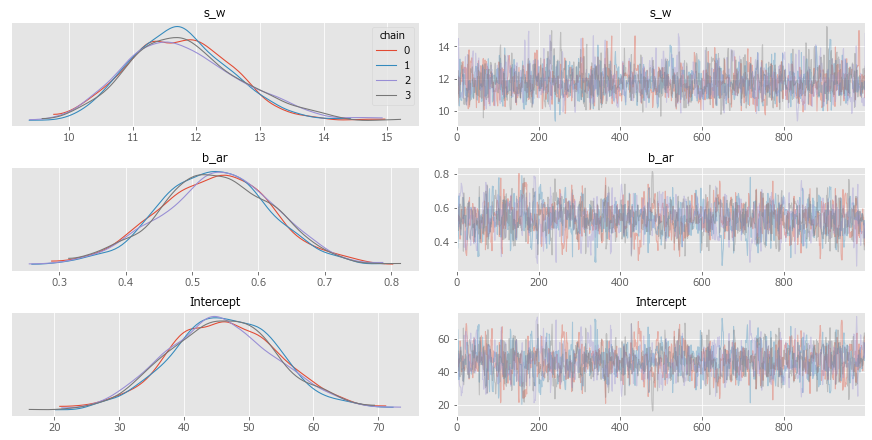

In [10]:
mcmc_sample = autoregressive.extract()
arviz.plot_trace(autoregressive,
                 var_names=["s_w", "b_ar", "Intercept"],
                 legend=True);